In [24]:
import torch
from torch import autograd
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Set, Optional, Union, Callable
from kan import KAN, LBFGS




In [26]:
device = torch.device("cuda:0")
print("Using device:", device)

rho = torch.tensor(1.0, device=device)
nu = torch.tensor(0.01, device=device)
eps = torch.tensor(1e-8, device=device)

width, height = 1.0, 1.0
num_points_x, num_points_y = 100, 100

x = torch.linspace(0, width, num_points_x, device=device)
y = torch.linspace(0, height, num_points_y, device=device)
X, Y = torch.meshgrid(x, y, indexing='ij')
coordinates = torch.stack([X.flatten(), Y.flatten()], dim=1)
coordinates = coordinates.requires_grad_()

model = KAN(width=[2,16,16, 3], grid=5, k=3, grid_eps=1.0,
            noise_scale_base=0., device=torch.device('cuda:0')).to(device)

Using device: cuda:0


In [28]:
# def batch_jacobian(func, x, create_graph=False):
#     # x in shape (Batch, Length)
#     def _func_sum(x):
#         return func(x).sum(dim=0)
#     return autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1, 0, 2)


def navier_stokes_residuals(coords):
    y_pred = model(coords)
    # grads = batch_jacobian(model, coords)
    # hess = autograd.functional.hessian(model,coords)
    u, v, p = y_pred[:, 0:1], y_pred[:, 1:2], y_pred[:, 2:3]
    u_xy = autograd.grad(u, coords, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    v_xy = autograd.grad(v, coords, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    p_xy = autograd.grad(p, coords, grad_outputs=torch.ones_like(p), create_graph=True)[0]
    u_x, u_y = u_xy[:, 0:1], u_xy[:, 1:2]
    v_x, v_y = v_xy[:, 0:1], v_xy[:, 1:2]
    p_x, p_y = p_xy[:, 0:1], p_xy[:, 1:2]

    u_xx = autograd.grad(u_x, coords, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0:1]
    u_yy = autograd.grad(u_y, coords, grad_outputs=torch.ones_like(u_y), create_graph=True)[0][:, 1:2]
    v_xx = autograd.grad(v_x, coords, grad_outputs=torch.ones_like(v_x), create_graph=True)[0][:, 0:1]
    v_yy = autograd.grad(v_y, coords, grad_outputs=torch.ones_like(v_y), create_graph=True)[0][:, 1:2]
    
#     u_x, u_y = grads[:, 0, 0], grads[:, 0, 1]
#     v_x, v_y = grads[:, 1, 0], grads[:, 1, 1]
#     p_x, p_y = grads[:, 2, 0], grads[:, 2, 1]

#     u_xx = hess[:,0,0]
#     u_yy = hess[:,1,1]

#     v_xx = hess[:,]

    

    continuity = u_x + v_y  # Assuming incompressibility (no source/sink terms)
    x_momentum = u * u_x + v * u_y + (1 / rho) * p_x - nu * (u_xx + u_yy)
    y_momentum = u * v_x + v * v_y + (1 / rho) * p_y - nu * (v_xx + v_yy)

    #coords are a Nx2 tensor where each row is [x, y]
    no_slip_mask = (coords[:, 0:1] == 0) |  (coords[:,1:2] == 0) |  (coords[:, 0:1] == width)  # No-slip at left,bottom and right 
    lid_mask = (coords[:, 1:2] == height)  # Top at y = height
    #right_mask = (coords[:, 0] == width)  # Outlet at x = width

    # Applying boundary conditions
    no_slip_loss = torch.mean(u[no_slip_mask] ** 2 + v[no_slip_mask] ** 2)  # u and v should be zero
    lid_loss = torch.mean((u[lid_mask] - 1) ** 2)  # u should be 1, v should be 0 at inlet
    #outlet_pressure_loss = torch.mean(p[outlet_mask] ** 2)  # p should be 0 at outlet

    # Combine all losses
    bc_loss = no_slip_loss + lid_loss 
    total_loss = torch.mean(continuity ** 2 + x_momentum ** 2 + y_momentum ** 2) + bc_loss
    return total_loss



writer = SummaryWriter()
Lossset=[]

def train():
    optimizer = LBFGS(model.parameters(), lr=1,
                      history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)
    steps = 250
    pbar = tqdm(range(steps), desc='Training Progress')
   
    for step in pbar:
        def closure():
            optimizer.zero_grad()
            loss = navier_stokes_residuals(coordinates)
          
            loss.backward()
            return loss
            

        optimizer.step(closure)
        if step % 5 == 0:
            current_loss = closure().item()
            Lossset.append(current_loss)
            pbar.set_description("Step: %d | Loss: %.3f" %
                                 (step, current_loss))
            writer.add_scalar('Loss/train', current_loss, step)


train()

writer.close()



Step: 10 | Loss: 0.025:  14%|█▍        | 14/100 [04:25<27:24, 19.12s/it]

<function matplotlib.pyplot.show(close=None, block=None)>

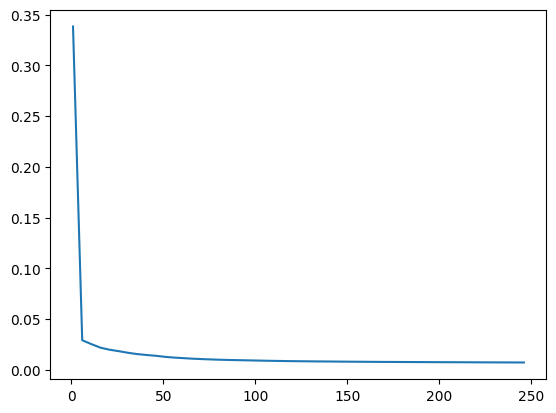

In [19]:
Xax=np.arange(1,250,5)
plt.plot(Xax,Lossset)
plt.show

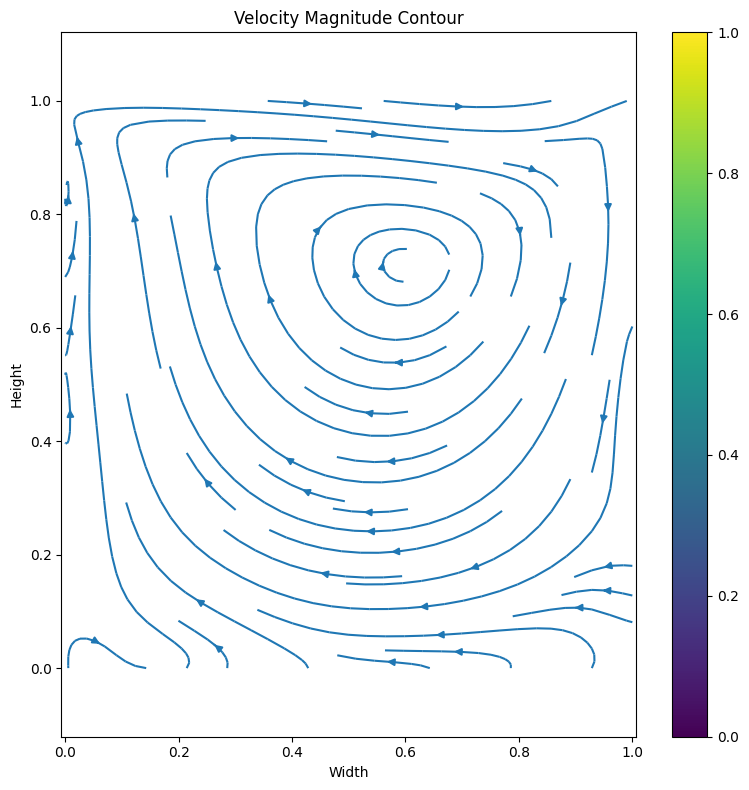

In [20]:
u_pred = model(coordinates)[:, 0].detach().reshape(
    num_points_x, num_points_y).T.cpu()

v_pred = model(coordinates)[:, 1].detach().reshape(
    num_points_x, num_points_y).T.cpu()


#magnitude = torch.sqrt(u_pred ** 2 + v_pred ** 2)
Y, X  = np.mgrid[0:width:100j,0:height:100j]

plt.figure(figsize=(8, 8))  # Set the figure size as needed
#plt.imshow(u_pred, extent=(0, width, 0, height), origin='lower', cmap='viridis')
plt.streamplot(X,Y,u_pred,v_pred,density=[0.5,1])
plt.colorbar()  # Add a colorbar to show the magnitude scale
plt.title('Velocity Magnitude Contour')
plt.xlabel('Width')
plt.ylabel('Height')

plt.axis('equal')  # Ensure the plot has equal scaling

plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig("cavity.png")
plt.show()


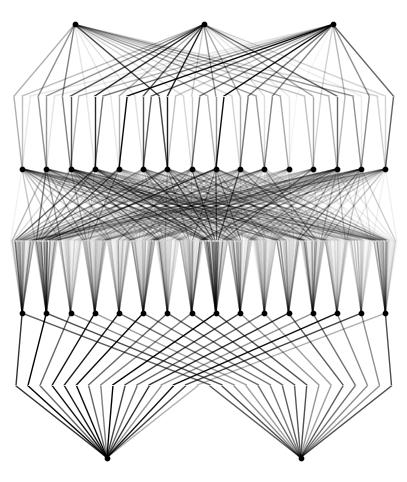

In [21]:
model.plot(beta=10)

In [22]:
torch.save(model.state_dict(), "model.pt")
